## Imports

In [1]:
import numpy as np
import pandas as pd
import datetime

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
train_df = pd.read_csv('../input/transformed_input/train_clean_owen')
ag_train = pd.read_csv('../input/transformed_input/aggregated_train_clean_owen')
test_df = pd.read_csv('../input/transformed_input/test_clean_owen')
spray_df = pd.read_csv('../input/transformed_input/spray_clean_owen')
weather_df = pd.read_csv('../input/transformed_input/weather_clean_owen')

In [3]:
train_df.Date = pd.to_datetime(train_df.Date)
ag_train.Date = pd.to_datetime(ag_train.Date)
test_df.Date = pd.to_datetime(test_df.Date)
spray_df.Date = pd.to_datetime(spray_df.Date)
weather_df.Date = pd.to_datetime(weather_df.Date)

In [4]:
def weather_stat (date, start_days_back, end_days_back, col, stat):
    '''
    date = the end date
    start_days_back = how far back the start day is (0 is day of)
    end_days_back = how far back the end day is, end day should be after start day (inclusive)
    col = the col where you are getting the stat from
    stat = 'a' for average, 'h' for high, 'l' for low
    station = '3' for both, '1' or '2'
    '''
    start_date = date - datetime.timedelta(start_days_back)
    end_date = date - datetime.timedelta(end_days_back)
    df = weather_df[(weather_df['Date']>start_date) & (weather_df['Date']<=end_date)]
    data = df[col]
    result = stat(data)
    return result

In [5]:
date = datetime.datetime(2013,6,1)
weather_stat(date, 7, 0, 'Tmax', np.mean)

75.14285714285714

## Aggregator

In [6]:
ag_train.WnvPresent.value_counts()

0    3649
1     194
Name: WnvPresent, dtype: int64

## 2013 Train

In [7]:
train_2013 = train_df[(train_df['Date']>datetime.datetime(2013,1,1)) & (train_df['Date']<datetime.datetime(2014,1,1))]

## Train test split

In [8]:
train = train_df.copy()

In [9]:
train.head()

,Date,Trap,Latitude,Longitude,NumMosquitos,WnvPresent,pipien,restuans
0,2007-06-29,T002,41.954690,-87.800991,2,0,1,1
1,2007-06-29,T015,41.974089,-87.824812,1,0,1,1
2,2007-06-29,T015,41.974089,-87.824812,2,0,0,1
3,2007-06-29,T046,41.891118,-87.654491,2,0,0,1
4,2007-06-29,T054,41.921965,-87.632085,3,0,1,1


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_index = train.index.tolist()

In [12]:
for i in train_index:
    trap = train.loc[i,'Trap']
    date = train.loc[i,'Date']

    this_week = ag_train[(ag_train['Trap']==trap) & (ag_train['Date']==date)]
    inx = np.max([this_week.index[0]-1,0])
    train.loc[i,'LastWeekWnvPresent'] = ag_train.loc[inx,'WnvPresent']

In [13]:
X = train[['Date', 'Trap','Latitude', 'Longitude', 'NumMosquitos',
       'pipien', 'restuans','LastWeekWnvPresent']]
y = train['WnvPresent']

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, stratify = y)

In [15]:
y_train.shape

(7059,)

In [16]:
copy1 = y_train[y_train == 1]
copy2 = y_train[y_train == 1]
y_train = pd.concat([y_train,copy1,copy2])

In [17]:
y_train.shape

(7941,)

In [18]:
duplicated_index = copy1.index.tolist()

In [19]:
copy1 = X.loc[duplicated_index,:].copy()
copy2 = X.loc[duplicated_index,:].copy()
X_train = pd.concat([X_train,copy1,copy2])

In [20]:
X_train.shape

(7941, 8)

In [21]:
y_train.value_counts()

0    6618
1    1323
Name: WnvPresent, dtype: int64

In [22]:
def add_weather(df):
    days = 7

    cols = ['Tmax']
    for col in cols:
        df[str(days)+'DayMax'+col] = df['Date'].map(lambda d: weather_stat(d, days, 0, col, np.max))

    cols = ['Tmin']
    for col in cols:
        df[str(days)+'DayMin'+col] = df['Date'].map(lambda d: weather_stat(d, days, 0, col, np.min))

    cols = ['Tavg', 'Depart', 'DewPoint', 'WetBulb', 'Heat','Cool', 'PrecipTotal', 'SunLight', 
            'Rain', 'Haze', 'Mist', 'Drizzle','Fog']
    for col in cols:
        df[str(days)+'DayMean'+col] = df['Date'].map(lambda d: weather_stat(d, days, 0, col, np.mean))
    
    return df

In [23]:
X_train = add_weather(X_train)
X_test = add_weather(X_test)

/Users/owencallen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/owencallen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/owencallen/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

In [24]:
X_train.drop(['Date','Trap'], axis=1, inplace=True)
X_test.drop(['Date','Trap'], axis=1, inplace=True)

/Users/owencallen/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


## Modeling

In [25]:
from sklearn.metrics import confusion_matrix, f1_score

def show_gs_classifier_results(model, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    print('best_params:',model.best_params_)
    dec = 3
    #train
    predictions = model.predict(X_train)
    cm = confusion_matrix(y_train, predictions)
    cm_train = pd.DataFrame(cm, 
                         columns=['predicted neg', 'predicted pos'],
                         index=['actual neg', 'actual pos'])
    cm_train = cm_train[['predicted pos','predicted neg']]
    cm_train = cm_train.T
    cm_train = cm_train[['actual pos','actual neg']]
    
    TP = cm_train.loc['predicted pos','actual pos']
    FP = cm_train.loc['predicted pos','actual neg']
    TN = cm_train.loc['predicted neg','actual neg']
    FN = cm_train.loc['predicted neg','actual pos']
    
    train_dict = {
        'Accuracy': np.round_((TP+TN)/(TP+FP+TN+FN),dec),
        'Sensitivity': np.round_(TP/(TP+FN),dec),
        'Specificity': np.round_(TN/(TN+FP),dec),
        'PPP': np.round_(TP/(TP+FP),dec),
        'NPP': np.round_(TN/(TN+FN),dec),
        'F1-score': np.round_(f1_score(y_train,predictions),dec)
    }
    
    #test
    predictions = model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    cm_test = pd.DataFrame(cm, 
                         columns=['predicted neg', 'predicted pos'],
                         index=['actual neg', 'actual pos'])
    cm_test = cm_test[['predicted pos','predicted neg']]
    cm_test = cm_test.T
    cm_test = cm_test[['actual pos','actual neg']]
    
    TP = cm_test.loc['predicted pos','actual pos']
    FP = cm_test.loc['predicted pos','actual neg']
    TN = cm_test.loc['predicted neg','actual neg']
    FN = cm_test.loc['predicted neg','actual pos']
    
    test_dict = {
        'Accuracy': np.round_((TP+TN)/(TP+FP+TN+FN),dec),
        'Sensitivity': np.round_(TP/(TP+FN),dec),
        'Specificity': np.round_(TN/(TN+FP),dec),
        'PPP': np.round_(TP/(TP+FP),dec),
        'NPP': np.round_(TN/(TN+FN),dec),
        'F1-score': np.round_(f1_score(y_test,predictions),dec)
    }

    metrics = pd.DataFrame([train_dict,test_dict], index=['train','test'])
    display(metrics)
    
    print('train confusion matrix')
    display(cm_train)
    print('test confusion matrix')
    display(cm_test)
    

In [26]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

%matplotlib inline
def gs_model_ROC (model, X, y):
    # Generate False positive rate and True positive rate
    predicted_proba = model.predict_proba(X)[:,-1]
    fpr, tpr, _ = roc_curve(y, predicted_proba)
    roc_auc = auc(fpr, tpr)

    # Plot 
    plt.figure(figsize = (8,8))

    line_weight = 2
    plt.plot(fpr, tpr, color="darkorange", lw = line_weight, label = "ROC Curve %0.2f" % roc_auc)

    plt.plot([0, 1], [0, 1], color="navy", lw = line_weight, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

best_params: {'model__C': 0.112, 'model__penalty': 'l2'}


,Accuracy,F1-score,NPP,PPP,Sensitivity,Specificity
train,0.861,0.465,0.883,0.648,0.363,0.961
test,0.913,0.268,0.951,0.283,0.255,0.957


train confusion matrix


,actual pos,actual neg
predicted pos,480,261
predicted neg,843,6357


test confusion matrix


,actual pos,actual neg
predicted pos,28,71
predicted neg,82,1584


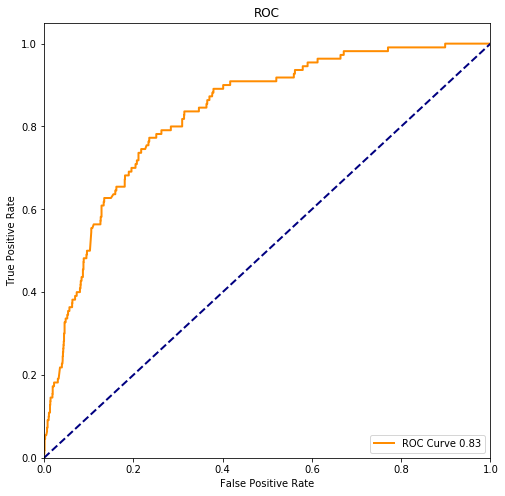

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
model = LogisticRegression()
poly = PolynomialFeatures(include_bias=False)
pipe_steps = [
    ('poly', poly),
    ('ss', StandardScaler()),
    ('model', model)
]

pipe = Pipeline(pipe_steps)

grid_params = {
    'model__penalty':['l1','l2'],
    'model__C':list(np.linspace(.001,1,10))
}

gs = GridSearchCV(pipe, grid_params, cv = 3, n_jobs=-1)

gs.fit(X_train,y_train)
show_gs_classifier_results(gs)
gs_model_ROC(gs,X_test,y_test)

best_params: {'model__C': 0.112, 'model__penalty': 'l2'}


,Accuracy,F1-score,NPP,PPP,Sensitivity,Specificity
train,0.861,0.465,0.883,0.648,0.363,0.961
test,0.913,0.268,0.951,0.283,0.255,0.957


train confusion matrix


,actual pos,actual neg
predicted pos,480,261
predicted neg,843,6357


test confusion matrix


,actual pos,actual neg
predicted pos,28,71
predicted neg,82,1584


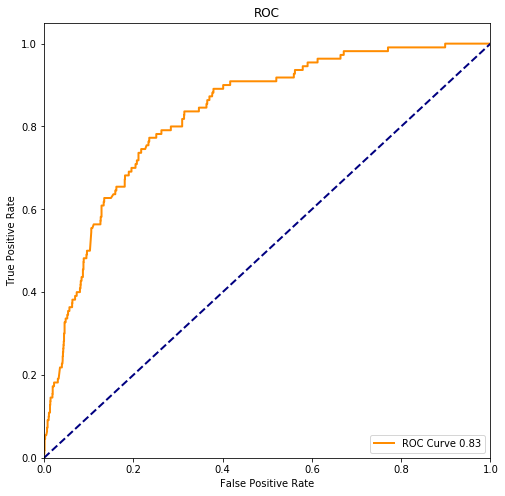

In [28]:
model = LogisticRegression()
ss = StandardScaler()
poly = PolynomialFeatures(include_bias=False)
pipe_steps = [
    ('poly', poly),
    ('ss', ss),
    ('model', model)
]

pipe = Pipeline(pipe_steps)

grid_params = {
    'model__penalty':['l1','l2'],
    'model__C':list(np.linspace(.001,1,10))
}

gs = GridSearchCV(pipe, grid_params, cv = 3, n_jobs=-1)

gs.fit(X_train,y_train)
show_gs_classifier_results(gs)
gs_model_ROC(gs,X_test,y_test)

In [29]:
poly = PolynomialFeatures(include_bias=False)
X_train_poly = poly.fit_transform(X_train)

log = LogisticRegression(C = 0.112, penalty = 'l2')
log.fit(X_train_poly,y_train)

LogisticRegression(C=0.112, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [30]:
len(poly.get_feature_names(X_train.columns))

252

In [31]:
log.coef_.T.shape

(252, 1)

In [32]:
coefs = pd.DataFrame(log.coef_, columns=poly.get_feature_names(X_train.columns)).T

In [33]:
coefs.sort_values(0, ascending=False, inplace=True)

In [34]:
coefs[coefs[0]**2>.005]

,0
7DayMeanDewPoint 7DayMeanSunLight,0.108116
pipien 7DayMaxTmax,0.089258
pipien 7DayMeanDewPoint,-0.073372
pipien 7DayMinTmin,-0.074440
7DayMinTmin 7DayMeanHeat,-0.086517
7DayMeanTavg^2,-0.089312
